# Part 1 Convolutional Neural Network for Fashion Product Classification

### Imports

In [29]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import random

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import *
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical, plot_model

from sklearn.metrics import confusion_matrix

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### Set randomness
Please note, due to the use of a GPU for training and inference, there will be some unavoidable randomness in the output. 

In [30]:
np.random.seed(237)
random.seed(237)
tf.random.set_seed(237)

### Load train and test labels

In [31]:
test = pd.read_csv("test.csv",
           header=0, 
           sep="	")
test

,imageid,label,productname
0,21131,Topwear,s.Oliver Women Solid White Top
1,27837,Others,Bulchee Men Plain Jeans Black Belt
2,47649,Shoes,Carlton London Men Brown Shoes
3,49717,Others,Park Avenue Black & Red Checked Tie
4,4868,Topwear,Levis Kids Boy's Darby Orange Polo Tshirt
...,...,...,...
3995,7928,Topwear,Proline Men Olive Green Polo T-shirt
3996,21254,Bags,Skybags Unisex Maroon Duffle Bag
3997,58463,Others,Fossil Men Black Belt
3998,38025,Watches,Q&Q Women Steel Dial Watch


In [32]:
train = pd.read_csv("train.csv",
           header=0, 
           sep="	")
train

,imageid,label,productname
0,2653,Bags,Murcia Women Leather Office Grey Bag
1,55997,Others,Colorbar Velvet Matte Temptation Lipstick 24MA
2,2640,Shoes,Carlton London Men Brown Formal Shoes
3,40565,Topwear,W Women Maroon Kurta
4,38932,Bottomwear,Gini and Jony Girls Pink Leggings
...,...,...,...
40436,5815,Topwear,Puma Men's Sports Grey T-shirt
40437,55200,Others,Lakme Lip Love Charmer Lip Conditioner
40438,11294,Bottomwear,Wrangler Men Blue Floyd Jeans
40439,30620,Topwear,Nike Men Printed Green T-shirt


### Load the images

Since there are a few grayscale images in the dataset, I decided to omit them.  I imagine any modern and quality product listing would have a colour image. 

In [33]:
def load_images(labels):
    images = []
    grayscale_img_ids = []
    for fname in labels['imageid']:
        img_arr = np.asarray(Image.open(os.path.join("images", str(fname)+".jpg")).resize((60, 80)))
        
        # don't add the image if its not RGB
        if len(img_arr.shape)<3:
            grayscale_img_ids.append(fname)
        else:
            images.append(img_arr/255.0)
    
    # the remove grayscale labels
    labels = labels[~labels['imageid'].isin(grayscale_img_ids)].copy()
    
    return labels, np.asarray(images) 

In [34]:
test_labels, test_images = load_images(test)

In [35]:
train_labels, train_images = load_images(train)

In [36]:
labels = train_labels['label'].unique().tolist()
labels

['Bags',
 'Others',
 'Shoes',
 'Topwear',
 'Bottomwear',
 'Innerwear',
 'Eyewear',
 'Jewellery',
 'Sandal',
 'Watches',
 'Fragrance',
 'Wallets',
 'Makeup']

### Prepare training data

In [37]:
# one hot encode the labels
y_train = to_categorical(train_labels["label"].apply(lambda x: labels.index(x)).to_numpy())
y_test = to_categorical(test_labels["label"].apply(lambda x: labels.index(x)).to_numpy())
x_train = train_images
x_test = test_images

In [38]:
print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

(40053, 80, 60, 3)
(40053, 13)
(3957, 80, 60, 3)
(3957, 13)


#### Show an example image

Others


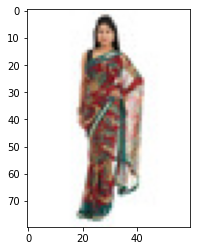

In [39]:
num = 1279
print(labels[np.argmax(y_test[num])])
plt.imshow(x_test[num])

#### Show the distribution of classes

In [40]:
d = pd.DataFrame(train_labels['label'].value_counts() / len(train_labels)*100)
d.columns=['Percentage of Training Dataset']
d.index.name = 'Category'
d

,Percentage of Training Dataset
Category,
Topwear,34.981150
Shoes,16.500637
Others,14.011435
Bags,6.853419
Bottomwear,6.146855
Watches,5.572616
Innerwear,4.042144
Eyewear,2.386837
Jewellery,2.344394


### Model Design

In [41]:
model_input = Input(shape=(80, 60, 3), name='img')

x = Conv2D(16, 3, activation='relu')(model_input)
x = MaxPool2D(pool_size=2)(x)
x = Dropout(0.1)(x)

x = Conv2D(32, 3, activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)
x = Dropout(0.1)(x)

x = Conv2D(64, 3, activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)
x = Dropout(0.1)(x)

x = Conv2D(128, 3, activation='relu')(x)
x = MaxPool2D(pool_size=2)(x)
x = Dropout(0.1)(x)


x = Flatten()(x)
x = Dense(128, activation='relu')(x)
model_output = Dense(13, activation='softmax')(x)

cnn = Model(model_input, model_output, name="simplecnn")
cnn.summary()


Model: "simplecnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img (InputLayer)             [(None, 80, 60, 3)]       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 78, 58, 16)        448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 39, 29, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 39, 29, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 37, 27, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 18, 13, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 18, 13, 32)        0 

In [42]:
cnn.compile(optimizer = "adam", 
           loss = "CategoricalCrossentropy",
           metrics=["accuracy"])

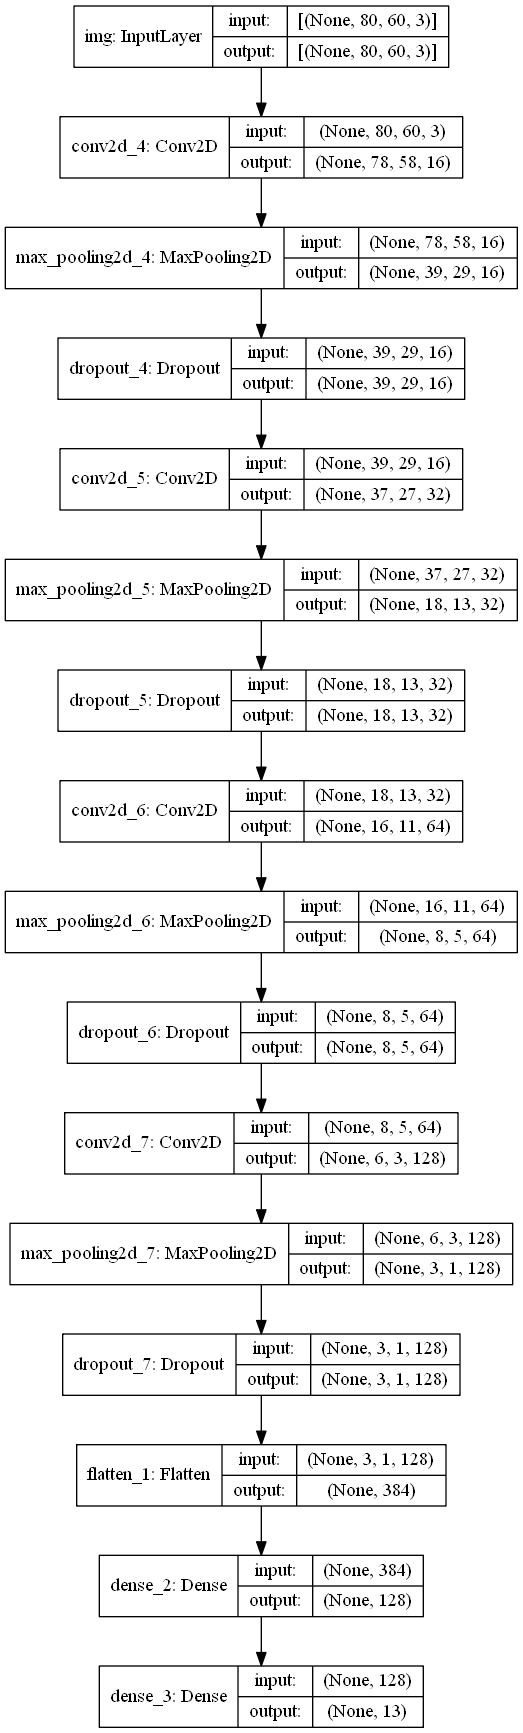

In [43]:
plot_model(cnn, "image_classifier.png", show_shapes=True)

### Train Model

In [44]:
history = cnn.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10)

Epoch 1/10
1252/1252 [==============================] - 7s 5ms/step - loss: 0.9885 - accuracy: 0.6937 - val_loss: 0.4112 - val_accuracy: 0.8744
Epoch 2/10
1252/1252 [==============================] - 6s 5ms/step - loss: 0.3818 - accuracy: 0.8818 - val_loss: 0.2969 - val_accuracy: 0.9078
Epoch 3/10
1252/1252 [==============================] - 6s 5ms/step - loss: 0.2927 - accuracy: 0.9104 - val_loss: 0.2307 - val_accuracy: 0.9242
Epoch 4/10
1252/1252 [==============================] - 6s 5ms/step - loss: 0.2507 - accuracy: 0.9214 - val_loss: 0.2686 - val_accuracy: 0.9164
Epoch 5/10
1252/1252 [==============================] - 6s 5ms/step - loss: 0.2292 - accuracy: 0.9266 - val_loss: 0.2442 - val_accuracy: 0.9171
Epoch 6/10
1252/1252 [==============================] - 6s 5ms/step - loss: 0.2023 - accuracy: 0.9343 - val_loss: 0.2078 - val_accuracy: 0.9328
Epoch 7/10
1252/1252 [==============================] - 6s 5ms/step - loss: 0.1874 - accuracy: 0.9388 - val_loss: 0.1983 - val_accuracy:

### Visualize Results

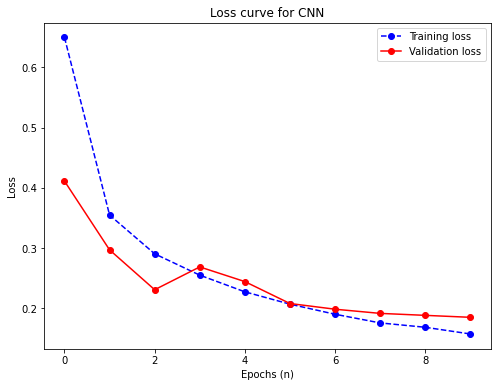

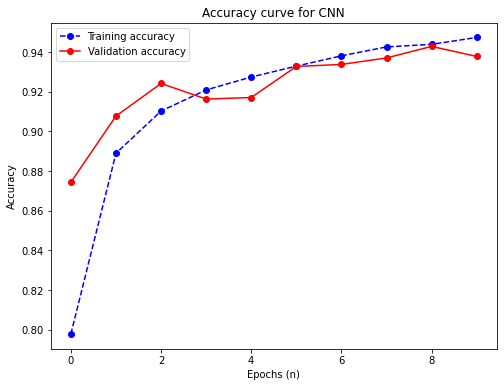

In [45]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], 'bo--')
plt.plot(history.history['val_loss'], 'ro-')
plt.ylabel('Loss')
plt.xlabel('Epochs (n)')
plt.legend(['Training loss', 'Validation loss'])
plt.title("Loss curve for CNN")
plt.show()
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], 'bo--')
plt.plot(history.history['val_accuracy'], 'ro-')
plt.ylabel('Accuracy')
plt.xlabel('Epochs (n)')
plt.title("Accuracy curve for CNN")
plt.legend(['Training accuracy', 'Validation accuracy'])
plt.show()

In [46]:
train_loss, train_acc = cnn.evaluate(x=x_train, y=y_train)
print("The model performed with a training accuracy of {:.2f}%".format(train_acc*100))

1252/1252 [==============================] - 3s 2ms/step - loss: 0.1052 - accuracy: 0.9648
The model performed with a training accuracy of 96.48%


In [47]:
test_loss, test_acc = cnn.evaluate(x=x_test, y=y_test)
print("The model performed with a testing accuracy of {:.2f}%".format(test_acc*100))

124/124 [==============================] - 0s 2ms/step - loss: 0.1848 - accuracy: 0.9378
The model performed with a testing accuracy of 93.78%


In [48]:
preds = cnn.predict(x_test)
preds = preds.argmax(1)
true = y_test.argmax(1)

#### A confusion matrix allows for more information on performance

In [49]:
cm = confusion_matrix(true, preds)

Text(0.5, 1.0, 'Confusion matrix for CNN')

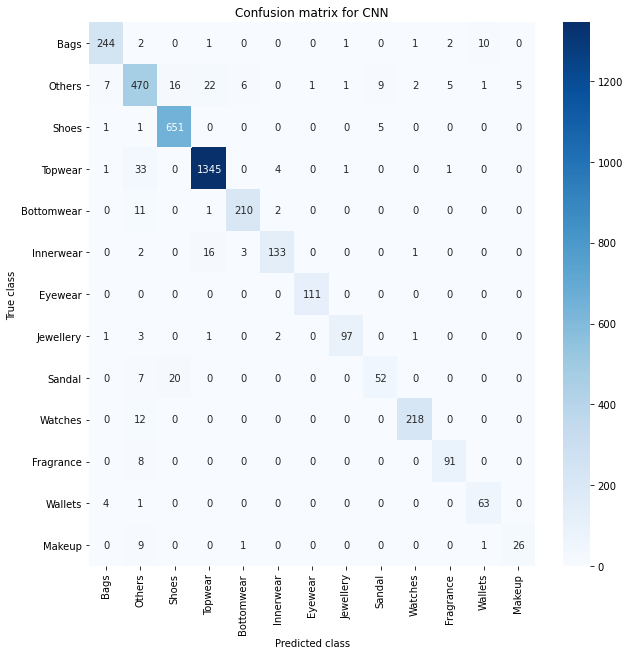

In [50]:
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Confusion matrix for CNN")

#### Check to ensure distribution of predictions matches distribution of labels

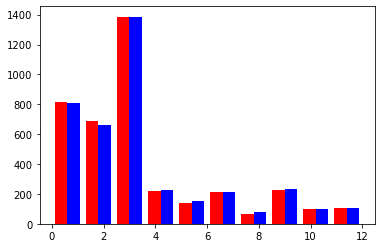

In [51]:
_ = plt.hist([preds, true], color=['r', 'b'])

We see that the distributions are very similar, which indicates that our model is learning each class, not just focusing on the top most frequent classes and almost never predicting rare classes.  
Therefore our model is handling the uneven distribution of class examples well. 

In [52]:
print("In summary, this model performs with a training accuracy of {:.2f}% and a testing accuracy of {:.2f}%. ".format(
    train_acc*100,
    test_acc*100
))

In summary, this model performs with a training accuracy of 96.48% and a testing accuracy of 93.78%. 
